In [1]:
from pathlib import Path

import os
import torch
import albumentations as A

from tracenet.utils.loader import get_loaders
from tracenet.utils.plot import plot_traces
from tracenet.models.detr import get_detr

In [2]:
data = 'mt'
data_dir = 'mtdata_real'
model_path = rf'models/happy-mountain-14/best_model.pth'
maxsize = 370

train_dir = 'train'
val_dir = 'val'
bs = 2
n_points = 2

In [3]:
train_dl, val_dl = get_loaders(data_dir, train_dir=train_dir, val_dir=val_dir, batch_size=bs, maxsize=maxsize)

In [4]:
imgs, targets, labels, masks = next(iter(train_dl));

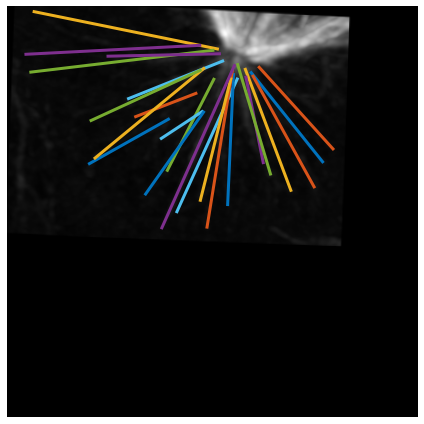

In [5]:
ind = 1
img_gt = plot_traces(imgs[ind], targets[ind]['boxes'], return_image=True)

## Prediction

In [6]:
model = get_detr(n_classes=1, n_points=n_points, 
                 pretrained=True, state_dict_path=model_path).eval();

Using cache found in /home/amedyukh/.cache/torch/hub/facebookresearch_detr_main


__floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').


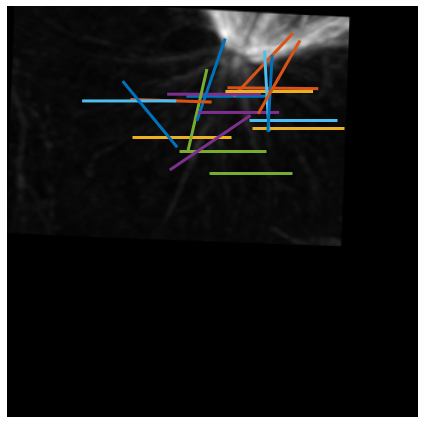

In [7]:
# propagate through the model
with torch.no_grad():
    outputs = model(imgs)

# keep only predictions with 0.7+ confidence
probas = outputs['pred_logits'].softmax(-1)[ind, :, :-1]
keep = probas.max(-1).values > 0.9
img_model = plot_traces(imgs[ind], outputs['pred_boxes'][ind, keep], return_image=True)

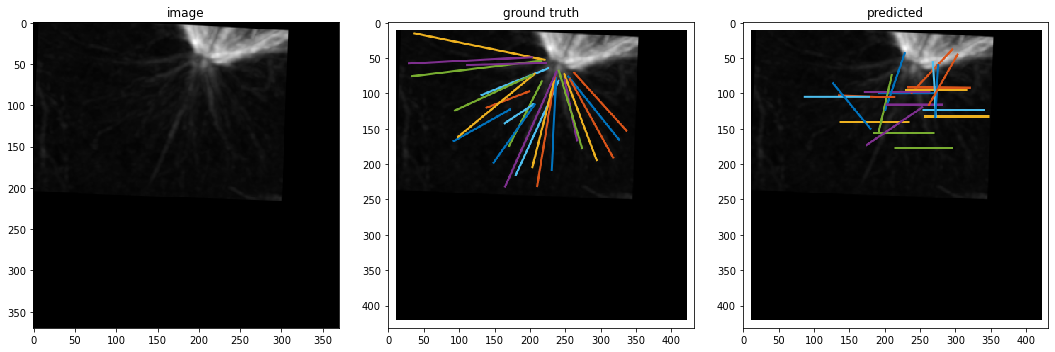

In [8]:
import pylab as plt
from skimage import io
fig, ax = plt.subplots(1, 3, figsize=(15,5))
titles = ['image', 'ground truth', 'predicted']
for i, im, in enumerate([imgs[ind].numpy().transpose(1,2,0), img_gt, img_model]):
    plt.sca(ax[i])
    plt.title(titles[i])
    s = int(0.6*im.shape[0])
    io.imshow(im)
plt.savefig('TRaceNet_real_data_train.png')